# Training our own sentiment analysis

But we're going to do it differently this time! Not just a list of pre-programmed words.

## Read in our data

Lots of docs? `glob.glob`, same as always.

In [1]:
import glob

# Go into reviews, then go into txt_sentoken,
# then go into BOTH 'pos' and 'neg' directories
# then get every text file inside of there
filenames = glob.glob("reviews/txt_sentoken/*/*.txt")
content = [open(filename).read() for filename in filenames]

In [2]:
import pandas as pd

# Create a dataframe
df = pd.DataFrame({
    'filename': filenames,
    'content': content
})

# Let's see them
df.head(2)

,content,filename
0,"plot : two teen couples go to a church party ,...",reviews/txt_sentoken/neg/cv000_29416.txt
1,the happy bastard's quick movie review \ndamn ...,reviews/txt_sentoken/neg/cv001_19502.txt


## The sentiment is in the filename, let's extract it

In [3]:
# Extract out the sentiment from the filename
df['sentiment'] = df.filename.str.extract("txt_sentoken/(.*)/cv", expand=False)
df.head(2)

,content,filename,sentiment
0,"plot : two teen couples go to a church party ,...",reviews/txt_sentoken/neg/cv000_29416.txt,neg
1,the happy bastard's quick movie review \ndamn ...,reviews/txt_sentoken/neg/cv001_19502.txt,neg


In [4]:
df.tail(2)

,content,filename,sentiment
1998,steven spielberg's second epic film on world w...,reviews/txt_sentoken/pos/cv998_14111.txt,pos
1999,"truman ( "" true-man "" ) burbank is the perfect...",reviews/txt_sentoken/pos/cv999_13106.txt,pos


# What are we doing? An introduction to CLASSIFICATION.

We have a bunch of movie reviews in categories. Maybe someone sends us a new review, what category does the new review belong in?

We're going to train a classifier to recognize positive and negative reviews, so that if someone sends us a new review, we'll know if it's something we want to see without having to actually read the review.

RULE IS: For classification algorithms, YOU MUST HAVE CATEGORIES ON YOUR ORIGINAL DATASET.

**For clustering**

1. You'll get a lot of documents
2. You feed it to an algorithm, tell it create `x` number of categories
3. The machine gives you back categories whether they make sense or not

**For classification (which we are doing now)**

1. You'll get a lot of documents
2. You'll classify some of them into categories that you know and love
3. You'll ask the algorithm what categories a new bunch of unlabeled documents end up in

All mean the same thing: CATEGORY = CLASS = LABEL

The reason why you use machine learning is to not do things manually. So if you can do things manually, do it. Otherwise just try different algorithms until one works well (but you might need to know some upsides or downsides of each to interpret that).

# Why do we want to classify anything?

Hmmmm, maybe to [identify fake news](http://www.fakenewschallenge.org/) without reading every story ever?

# How are we classifying? NAIVE BAYES.

## How does Naive Bayes work?

NAIVE BAYES WORKS WITH TEXT (kind of)

**Bayes Theorem (kind of)**

* If you see a word that is normally in a spam email, there's a higher chance it's spam
* If you see a word that is normally in a non-spam email, there's a higher chance it's not spam

**Naive:** every word/feature/etc is independent of any other word

FOR US: If you see words that are normally in positive reviews, it's probably a positive review.

Secret trick: you can't just use text, you have to convert into numbers (vectorization to the rescue)

## Types of Naive Bayes

Naive Bayes works on words, and SOMETIMES your text is long and SOMETIMES your text is short.

**Multinominal Naive Bayes - (multiple numbers)**: You count the words. You care about whether a word appears once or twice or three times or ten times. *This is better for long passages*

**Bernoulli Naive Bayes - True/False Bayes:** You only care if the word shows up (`True`) or it doesn't show up (`False`) - *this is better for short passages*

What kind of Bayes should we use this time?

# Preparing our data (2 steps)

Remember, machine learning **only likes numbers**, so we need to jump through some hoops first.

## Prep 1: Convert our labels into numbers

Our labels are only `neg` and `pos`, so maybe we could just make positive 1 and negative 0?

This is a way to do it if you like being fancy and manually doing things...

In [8]:
def make_label(row):
    if row.sentiment == "pos":
        return 1
    else:
        return 0

df['sentiment_label'] = df.apply(make_label, axis=1)
df.head(3)

,content,filename,sentiment,sentiment_label
0,"plot : two teen couples go to a church party ,...",reviews/txt_sentoken/neg/cv000_29416.txt,neg,0
1,the happy bastard's quick movie review \ndamn ...,reviews/txt_sentoken/neg/cv001_19502.txt,neg,0
2,it is movies like these that make a jaded movi...,reviews/txt_sentoken/neg/cv002_17424.txt,neg,0


...but with 0/1 it's really easier to say "sentiment, are you positive?" and get `True` and `False` and then use `.astype(int)` to convert it to `0`/`1`.

In [9]:
df['sentiment_label'] = (df.sentiment == 'pos').astype(int)
df.head(3)

,content,filename,sentiment,sentiment_label
0,"plot : two teen couples go to a church party ,...",reviews/txt_sentoken/neg/cv000_29416.txt,neg,0
1,the happy bastard's quick movie review \ndamn ...,reviews/txt_sentoken/neg/cv001_19502.txt,neg,0
2,it is movies like these that make a jaded movi...,reviews/txt_sentoken/neg/cv002_17424.txt,neg,0


In [10]:
df.tail(3)

,content,filename,sentiment,sentiment_label
1997,"glory--starring matthew broderick , denzel was...",reviews/txt_sentoken/pos/cv997_5046.txt,pos,1
1998,steven spielberg's second epic film on world w...,reviews/txt_sentoken/pos/cv998_14111.txt,pos,1
1999,"truman ( "" true-man "" ) burbank is the perfect...",reviews/txt_sentoken/pos/cv999_13106.txt,pos,1


## Preparation 2: we need to build our list of features

That's going to be our **list of words**. Same vectorizer thing we **always use**.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words='english')
matrix = vec.fit_transform(df.content)
features_df = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())
features_df.head()

,00,000,0009f,007,00s,03,04,05,05425,10,...,zukovsky,zulu,zundel,zurg,zus,zweibel,zwick,zwigoff,zycie,zzzzzzz
0,0,0,0,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Using our classifier

##  Step 1: Import and create the classifier

What kind of Bayes classifier are we going to use?

In [45]:
from sklearn import naive_bayes

clf = naive_bayes.MultinomialNB()

## Step 2: Training the classifier

Teaching a classifier is called **training** or **fitting**. The classifier needs us to give it two things:
    
* **Our training features**: what the words are
* **Our training labels**: whether it's positive or negative

### What are our features?

Remember, numbers only!

In [46]:
features_df.head()

,00,000,0009f,007,00s,03,04,05,05425,10,...,zukovsky,zulu,zundel,zurg,zus,zweibel,zwick,zwigoff,zycie,zzzzzzz
0,0,0,0,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### What are our labels?

Remember, numbers only!

In [47]:
df.sentiment.head()

0    neg
1    neg
2    neg
3    neg
4    neg
Name: sentiment, dtype: object

In [48]:
df.sentiment_label.head()

0    0
1    0
2    0
3    0
4    0
Name: sentiment_label, dtype: int64

### Now let's actually train/teach/fit our classifier

Remember, this is called **fitting**, so it's going to be `clf.fit`. We'll also refer to it as training or maybe even teaching.

* First parameter is the **features**
* Second parameter is the **labels**

So easy.

In [49]:
clf.fit(features_df, df.sentiment_label)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

No errors = we did a good job.

## Step 3: Using the classifier

Now that we trained it, how do we use it? Well, the point of a classifier is to **process new content to see which category it belongs in**, so let's get some new content.

In [50]:
texts = [
    "I hate this movie it's terrible it's no good at all",
    "I love this directory his movies are great",
    "I don't like this excellent movie. It'good but I won't see it again."
]

### Step 3.1: Preparing our incoming data

Remember when we did `vec.fit_transform`? That had the vectorizer learn all of the words (fit) and then count all the words (transform). Since it's already memorized all of the words that went into the classifier, we don't want to teach it any new ones - we just want it to count some new sentences.

In [51]:
matrix = vec.transform(texts)
matrix

<3x39354 sparse matrix of type '<class 'numpy.int64'>'
	with 13 stored elements in Compressed Sparse Row format>

### Step 3.2: Predicting our incoming data

Once we have another matrix, we can use `clf.predict` to predict the labels for our sentences. We have to give it the **matrix**, though, since it doesn't understand words.

In [52]:
clf.predict(matrix)

array([0, 1, 1])

That `[0,1]` matches up with our labels - it means the first one is negative and the second one is positive. What words does it use to decide? **Use this cut-and-pasted code!**

In [53]:
# From http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html
import numpy as np

"""Prints features with the highest coefficient values, per class"""
class_labels = ['pos', 'neg']
feature_names = vec.get_feature_names()
for i, class_label in enumerate(class_labels):
    try:
        top10 = np.argsort(clf.coef_[i])[-10:]
        features_names = vec.get_feature_names()
        print("%s: %s" % (class_label, " ".join(features_names[j] for j in top10)))
    except:
        pass

pos: characters life character time story good just like movie film


## Step 4: Testing our classifier

The big question here is **but is our classifier actually any good?**

Even though we **built** a classifier, that doesn't actually **mean anything.** Maybe it's horrible. How can we test it?

It'd be cheating if we tested it against something it already knew, so we need to get a little fancier than that.

### Step 4.1: Preparating our split

I always call this test/train split and then type it wrong.

In [54]:
# train_test_split will split our data into two parts
from sklearn.model_selection import train_test_split

# Splitting into...
# X = are all our features
# y = are all our labels
# X_train are our features to train on (80%)
# y_train are our labels to train on (80%)
# X_test are our features to test on (20%)
# y_train are our labels to test on (20%)

X_train, X_test, y_train, y_test = train_test_split(
    features_df.values, # These are our problems (the reviews)
    df.sentiment_label, # These are our answers (the sentiment)
    test_size=0.2) # 20% of them should be for the test

# the first parameter is our FEATURES. can't just do words_df, it won't work :(
# the second parameter is the LABEL as a number (so 0/1, not neg/pos)
# 80% training, 20% testing

### What do those variables look like?

What are `X_train` and `X_test`?

In [55]:
# We are taking 1600 reviews for you to study
X_train.shape

(1600, 39354)

What are `y_train` and `y_test`?

In [56]:
y_train.head()

1361    1
648     0
1872    1
1813    1
1353    1
Name: sentiment_label, dtype: int64

### Step 4.2: Fitting and scoring against our test data

Now we'll fit again with **only our training data**, then test it against the **testing data** with `clf.score`.

In [57]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [58]:
clf.score(X_test, y_test)

0.78249999999999997

While we're at it, how does it do with things it's already seen?

# What about other classifiers?

There are a handful of other classifiers, and some might be better! While there are general rules about what kind to use, usually you just switch around until you get the best performance. We'll go more in-depth next week, but let's play around with one for now.

## Decision Trees

This is a simple one to understand called a **decision tree**, they're usually pretty good.

### Step 1: Import and create the classifier

In [63]:
from sklearn import tree

# Let's add max_depth=3 before we draw!
clf = tree.DecisionTreeClassifier(max_depth=3)

### Step 2: Train and score the new classifier

We have fewer steps this time because we've already **converted our data to numbers**, done our splits and all of that.

In [64]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [65]:
clf.score(X_test, y_test)

0.60750000000000004

Okay, they might not be that good **this** time, but how does it do on data it's already seen?

In [66]:
clf.score(X_train, y_train)

0.66374999999999995

What a wreck! This is called **overfitting** and we'll, yes, talk about it more next week.

### Step 3: Understanding

As a reward for your hard work, let's draw a pretty picture. We'll need to **remake the classifier so it can be drawn** - go up and change the classifier to `clf = tree.DecisionTreeClassifier(max_depth=3)` and re-run the fitting and scoring.

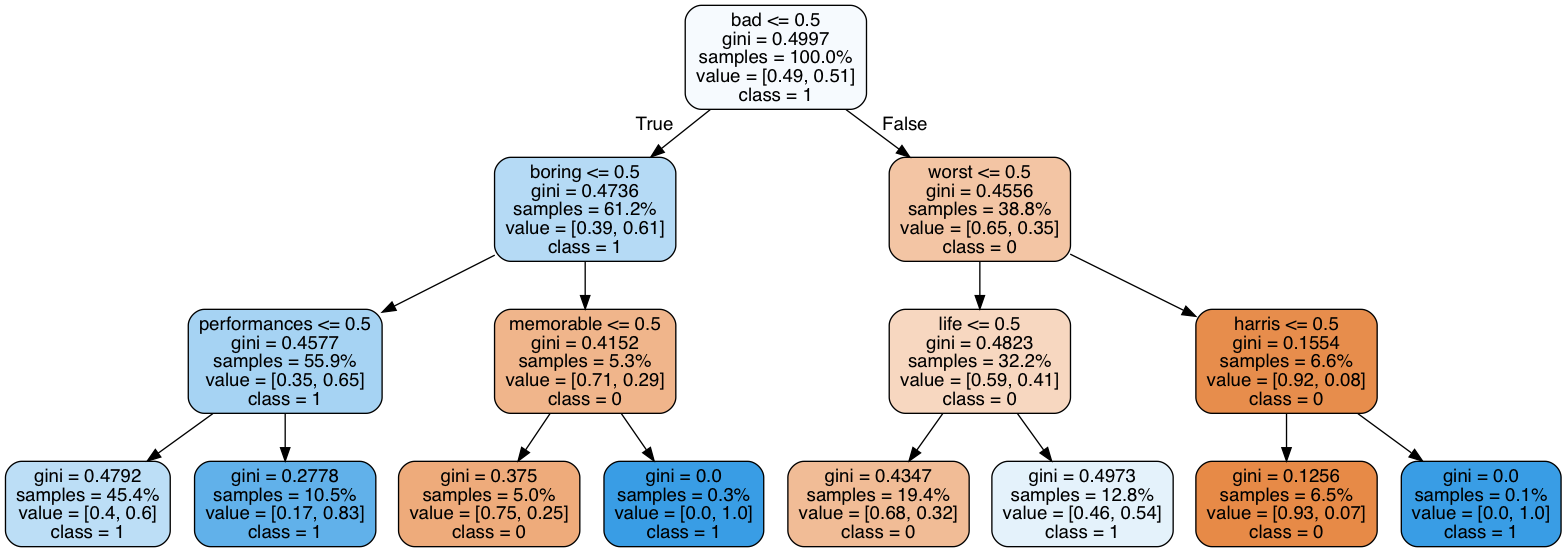

In [70]:
%matplotlib inline

import pydotplus
from IPython.display import Image  

dot_data = tree.export_graphviz(clf, out_file=None, 
    feature_names=vec.get_feature_names(),  
    class_names=clf.classes_.astype(str),  
    filled=True, rounded=True,  proportion=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

# Epilogue

Let's read some [fake news challenge code](https://github.com/FakeNewsChallenge/fnc-1-baseline/blob/master/feature_engineering.py)!